In [10]:
# ==============================================================================
# FAKE NEWS DETECTION MODEL
# ==============================================================================
# This script builds a machine learning model to classify news articles as
# REAL or FAKE using NLP techniques.
#
# Tech Stack: Python, Pandas, Scikit-learn, NLTK
#
# To Run This Script:
# 1. Make sure you have a CSV file named 'news.csv' in the same directory.
#    The CSV should contain 'text' and 'label' columns. A common dataset for
#    this can be found on Kaggle.
# 2. Run `pip install pandas scikit-learn nltk` if you don't have the libraries.
# 3. The first time you run this, it may require you to download the 'stopwords'
#    corpus from NLTK.
# ==============================================================================

# ------------------------------------------------------------------------------
# 1. IMPORTING NECESSARY LIBRARIES
# ------------------------------------------------------------------------------
import pandas as pd
import numpy as np
import re
import itertools
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Libraries imported successfully.")


Libraries imported successfully.


In [11]:
# ------------------------------------------------------------------------------
# 2. LOADING AND PREPARING THE DATA
# ------------------------------------------------------------------------------
print("\n--- Loading and Preparing Data ---")

# Load the datasets from two separate files: 'true.csv' and 'fake.csv'
try:
    df_true = pd.read_csv('True.csv')
    df_fake = pd.read_csv('Fake.csv')
    print("Datasets 'true.csv' and 'fake.csv' loaded successfully.")

    # Add a 'label' column to identify REAL and FAKE news
    df_true['label'] = 'REAL'
    df_fake['label'] = 'FAKE'

    # Combine the two dataframes into a single one
    df = pd.concat([df_true, df_fake], ignore_index=True)

    # Shuffle the combined dataset to ensure random distribution
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    print("Combined and shuffled the datasets.")
    print(f"Combined dataset shape: {df.shape}")
    print(df.head())

except FileNotFoundError as e:
    print("\n---")
    # More specific error message
    print(f"Error: The file '{e.filename}' was not found.")
    print("Please ensure both 'true.csv' and 'fake.csv' are in the same directory as this script.")
    print("---")
    exit()


# Check for missing values
print("\nChecking for missing values:")
print(df.isnull().sum())
df.dropna(inplace=True) # Drop rows with missing values if any
print("Missing values handled.")

# Get the labels
labels = df.label
print(f"\nLabels found: {labels.unique()}")




--- Loading and Preparing Data ---
Datasets 'true.csv' and 'fake.csv' loaded successfully.
Combined and shuffled the datasets.
Combined dataset shape: (44898, 5)
                                               title  \
0   BREAKING: GOP Chairman Grassley Has Had Enoug...   
1   Failed GOP Candidates Remembered In Hilarious...   
2   Mike Pence’s New DC Neighbors Are HILARIOUSLY...   
3  California AG pledges to defend birth control ...   
4  AZ RANCHERS Living On US-Mexico Border Destroy...   

                                                text       subject  \
0  Donald Trump s White House is in chaos, and th...          News   
1  Now that Donald Trump is the presumptive GOP n...          News   
2  Mike Pence is a huge homophobe. He supports ex...          News   
3  SAN FRANCISCO (Reuters) - California Attorney ...  politicsNews   
4  Twisted reasoning is all that comes from Pelos...      politics   

               date label  
0     July 21, 2017  FAKE  
1       May 7, 2016  FA

In [12]:
# ------------------------------------------------------------------------------
# 3. TEXT PREPROCESSING
# ------------------------------------------------------------------------------
print("\n--- Preprocessing Text Data ---")

# Initialize the Porter Stemmer and get English stopwords
ps = PorterStemmer()
stop_words = stopwords.words('english')

def preprocess_text(text):
    """
    Cleans and preprocesses a single text entry.
    - Removes non-alphabetic characters
    - Converts to lowercase
    - Splits into words
    - Applies stemming and removes stopwords
    """
    # Use regex to keep only alphabetic characters
    review = re.sub('[^a-zA-Z]', ' ', text)
    review = review.lower()
    review = review.split()

    # Stem words and remove stopwords
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    return review

# Apply the preprocessing function to the 'text' column
# This can take a few minutes on a large dataset
print("Applying preprocessing to all articles... (This may take a moment)")
corpus = df['text'].apply(preprocess_text)
print("Text preprocessing complete.")



--- Preprocessing Text Data ---
Applying preprocessing to all articles... (This may take a moment)
Text preprocessing complete.


In [14]:
# ------------------------------------------------------------------------------
# 4. FEATURE EXTRACTION (TF-IDF)
# ------------------------------------------------------------------------------
print("\n--- Performing Feature Extraction using TF-IDF ---")

# Separate the data into features (X) and labels (y)
X = corpus
y = labels

# Initialize the TF-IDF Vectorizer
# max_df=0.7 -> ignore terms that appear in more than 70% of documents
# stop_words='english' -> remove common English words
tfidf_vectorizer = TfidfVectorizer(max_df=0.7, stop_words='english')

# Fit and transform the training data
tfidf_X = tfidf_vectorizer.fit_transform(X)
print(f"TF-IDF matrix shape: {tfidf_X.shape}")




--- Performing Feature Extraction using TF-IDF ---
TF-IDF matrix shape: (44898, 89453)


In [15]:
# ------------------------------------------------------------------------------
# 5. SPLITTING DATA AND TRAINING THE MODEL
# ------------------------------------------------------------------------------
print("\n--- Splitting Data and Training the Model ---")

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the PassiveAggressiveClassifier
# This is a great choice for text classification as it works well with high-dimensional data
pac = PassiveAggressiveClassifier(max_iter=100)

# Train the model
pac.fit(X_train, y_train)
print("Model training complete.")




--- Splitting Data and Training the Model ---
Model training complete.



--- Evaluating Model Performance ---
Model Accuracy: 99.29%

Confusion Matrix:
[[4654   42]
 [  22 4262]]


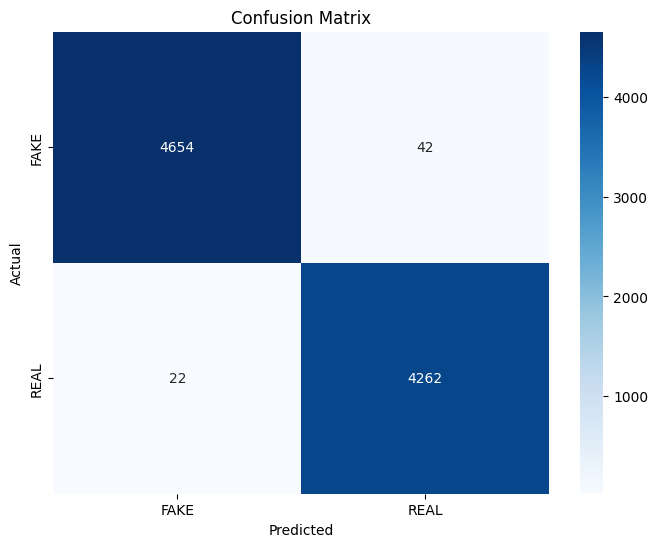


Classification Report:
              precision    recall  f1-score   support

        FAKE       1.00      0.99      0.99      4696
        REAL       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [16]:
# ------------------------------------------------------------------------------
# 6. EVALUATING THE MODEL
# ------------------------------------------------------------------------------
print("\n--- Evaluating Model Performance ---")

# Make predictions on the test set
y_pred = pac.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy * 100:.2f}%')

# Display the confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
# Plotting the confusion matrix for better visualization
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Display the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['FAKE', 'REAL']))


In [17]:
# ------------------------------------------------------------------------------
# 7. PREDICTING ON NEW, UNSEEN NEWS ARTICLES
# ------------------------------------------------------------------------------
print("\n--- Testing the Model on New Articles ---")

def predict_news(news_article):
    """
    Takes a raw news article string, preprocesses it, transforms it with
    the trained TF-IDF vectorizer, and predicts its label.
    """
    processed_article = preprocess_text(news_article)
    tfidf_article = tfidf_vectorizer.transform([processed_article])
    prediction = pac.predict(tfidf_article)
    return prediction[0]

# Example Articles
real_news_example = "The stock market saw a significant surge today after the central bank announced a cut in interest rates, aiming to boost economic activity. Investors reacted positively, with major indices closing at an all-time high."
fake_news_example = "BREAKING: Scientists have discovered a new species of flying elephants in the Amazon rainforest. The government is trying to cover it up, but we have exclusive photos from a whistleblower. This changes everything we know about biology."

# Predict and print results
print(f"\nPrediction for Real News Example: '{predict_news(real_news_example)}'")
print(f"Prediction for Fake News Example: '{predict_news(fake_news_example)}'")


--- Testing the Model on New Articles ---

Prediction for Real News Example: 'FAKE'
Prediction for Fake News Example: 'FAKE'
